<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/2D2V%20ABHILASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [707]:
import numpy as np
import h5py
from scipy.fftpack import fftfreq
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt

In [708]:
def fraction_finder(positions_x, positions_y, x_grid, y_grid, dx, dy):
    '''
    function fraction_finder(positions_x, positions_y, x_grid, y_grid, dx, dy)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x positions_y and length_domain_y

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.

        positions_y: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in
        x and y directions respectively


        dx, dy: This is the distance between any two consecutive grid nodes of the position grid
        in x and y directions respectively

    -----------------------------------------------------------------------
    returns: x_frac, y_frac
        This function returns the fractions of grid cells needed to perform the 2D charge deposition

    '''
    x_frac = (positions_x - np.sum(x_grid[0])) / dx
    y_frac = (positions_y - np.sum(y_grid[0])) / dy

    return x_frac, y_frac

In [709]:
def periodic_particles(positions_x, positions_y, length_domain_x, length_domain_y):
    '''
    function periodic_particles(positions_x, length_domain_x)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x positions_y and length_domain_y

        positions_x, positions_y: One dimensional arrays of size equal to number of particles
        taken in the PIC code. It contains the positions of particles in x and y directions
        respectively

        length_domain_x, length_domain_y: This is the length of the domain in x and y directions respectively.
        The domain is assumed to be from x = 0 to x = length_domain_x

    -----------------------------------------------------------------------
    returns: positions_x, positions_y
        This function returns the modified positions_x and positions_y such that particle previously
        gone outside the domain through the left boundary enter via the right boundary and vice versa.
        In other words, the function implements periodic boundary conditions for the particles.

    '''

    # NumPy implementation
    # Determine indices of particles which have gone outside the domain
    # through right boundary
    outside_domain_right_x = np.where(positions_x >= length_domain_x)
    outside_domain_top_y = np.where(positions_y >= length_domain_y)

    # Determine indices of particles which have gone outside the domain
    # through left boundary
    outside_domain_left_x = np.where(positions_x < 0)
    outside_domain_bottom_y = np.where(positions_y < 0)

    if len(outside_domain_right_x[0]) > 0:
        # Apply periodic boundary conditions
        positions_x[outside_domain_right_x] -= length_domain_x

    if len(outside_domain_top_y[0]) > 0:
        # Apply periodic boundary conditions
        positions_y[outside_domain_top_y] -= length_domain_y

    if len(outside_domain_left_x[0]) > 0:
        # Apply periodic boundary conditions
        positions_x[outside_domain_left_x] += length_domain_x

    if len(outside_domain_bottom_y[0]) > 0:
        # Apply periodic boundary conditions
        positions_y[outside_domain_bottom_y] += length_domain_y

    return positions_x, positions_y

In [710]:
def periodic_ghost(field, ghost_cells):
    '''
    function periodic_ghost(field, ghost_cells)
    -----------------------------------------------------------------------
    Input variables: field, ghost_cells

      field: A 2-dimensional array representing an input field. (columns--->x, rows---->y)

      ghost_cells: Number of ghost cells taken in the domain

    -----------------------------------------------------------------------
    returns: field
      This function returns the modified field with appropriate values assigned to the ghost nodes to
      ensure periodicity in the field.
    '''
    len_y, len_x = field.shape  # Get the dimensions of the field array

    # Apply periodic boundary conditions
    field[0:ghost_cells, :] = field[len_y - 2 * ghost_cells:len_y - ghost_cells, :]
    field[:, 0:ghost_cells] = field[:, len_x - 2 * ghost_cells:len_x - ghost_cells]
    field[len_y - ghost_cells:len_y, :] = field[ghost_cells + 1:2 * ghost_cells + 1, :]
    field[:, len_x - ghost_cells:len_x] = field[:, ghost_cells + 1:2 * ghost_cells + 1]

    return field

In [711]:
def charge_b1_depositor(charge_electron, positions_x, positions_y, x_grid, y_grid, ghost_cells, length_domain_x, length_domain_y):
    '''
    function charge_b1_depositor(charge_electron,positions_x, positions_y,x_grid, y_grid,ghost_cells,length_domain_x, length_domain_y)
    -----------------------------------------------------------------------
    Input variables: charge, zone_x, frac_x, x_grid, dx

        charge_electron: This is a scalar denoting the charge of the macro particle in the PIC code.

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.

        positions_y:  An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in
        x and y directions.

        ghost_cells: This is the number of ghost cells in the domain

        length_domain_x, length_domain_x: This is the length of the domain in x and y.

    -----------------------------------------------------------------------
    returns: rho

        rho: This is an array containing the charges deposited at the density grid nodes.
    '''
    number_of_particles = len(positions_x)

    x_charge_zone = np.zeros(4 * number_of_particles, dtype=np.uint32)
    y_charge_zone = np.zeros(4 * number_of_particles, dtype=np.uint32)

    # calculating the number of grid cells
    nx = x_grid.size - 1 - 2 * ghost_cells  # number of zones
    ny = y_grid.size - 1 - 2 * ghost_cells  # number of zones

    dx = length_domain_x / nx
    dy = length_domain_y / ny

    # Determining the left(x) and bottom (y) indices of the left bottom corner grid node of
    # the grid cell containing the particle
    x_zone = np.floor(np.abs(positions_x - np.sum(x_grid[0])) / dx).astype(np.uint32)
    y_zone = np.floor(np.abs(positions_y - np.sum(y_grid[0])) / dy).astype(np.uint32)

    x_zone_plus = x_zone + 1
    y_zone_plus = y_zone + 1

    # Calculating the fractions needed for calculating the weights
    dy_by_delta_y = (1 / dy) * (positions_y - y_grid[y_zone])
    dy_by_delta_y_complement = 1 - dy_by_delta_y

    dx_by_delta_x = (1 / dx) * (positions_x - x_grid[x_zone])
    dx_by_delta_x_complement = 1 - dx_by_delta_x

    # Calculating the weights at all corners
    # Order of corners is available on the main thesis document
    # order -----bottom right --->bottom left---->top left-----> top right
    weight_corner1 = dy_by_delta_y_complement * dx_by_delta_x_complement
    weight_corner2 = dy_by_delta_y * dx_by_delta_x_complement
    weight_corner3 = dy_by_delta_y * dx_by_delta_x
    weight_corner4 = dy_by_delta_y_complement * dx_by_delta_x

    charge_by_dxdy = charge_electron / (dx * dy)

    corner1_charge = weight_corner1 * charge_by_dxdy
    corner2_charge = weight_corner2 * charge_by_dxdy
    corner3_charge = weight_corner3 * charge_by_dxdy
    corner4_charge = weight_corner4 * charge_by_dxdy

    # Concatenating the all the weights for all 4 corners into one vector all_corners_weighted_charge
    all_corners_weighted_charge = np.concatenate((corner1_charge, corner2_charge, corner3_charge, corner4_charge))

    # concatenating the x indices into x_charge_zone
    x_charge_zone[0 * number_of_particles:1 * number_of_particles] = x_zone
    x_charge_zone[1 * number_of_particles:2 * number_of_particles] = x_zone
    x_charge_zone[2 * number_of_particles:3 * number_of_particles] = x_zone_plus
    x_charge_zone[3 * number_of_particles:4 * number_of_particles] = x_zone_plus

    # concatenating the x indices into x_charge_zone
    y_charge_zone[0 * number_of_particles:1 * number_of_particles] = y_zone
    y_charge_zone[1 * number_of_particles:2 * number_of_particles] = y_zone_plus
    y_charge_zone[2 * number_of_particles:3 * number_of_particles] = y_zone_plus
    y_charge_zone[3 * number_of_particles:4 * number_of_particles] = y_zone

    return x_charge_zone, y_charge_zone, all_corners_weighted_charge

In [712]:
def cloud_charge_deposition(charge_electron, number_of_electrons, positions_x, positions_y, x_grid, y_grid, shape_function, ghost_cells, length_domain_x, length_domain_y, dx, dy):
    '''
    function cloud_charge_deposition(charge_electron, number_of_electrons, positions_x, positions_y, x_grid, y_grid, shape_function, ghost_cells, length_domain_x, length_domain_y, dx, dy)
    -----------------------------------------------------------------------
    Input variables:
    charge_electron: This is a scalar denoting the charge of the macro particle in the PIC code.
    positions_x: An one-dimensional array of size equal to the number of particles taken in the PIC code. It contains the positions of particles in the x-direction.
    positions_y: An one-dimensional array of size equal to the number of particles taken in the PIC code. It contains the positions of particles in the y-direction.
    x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in x and y directions.
    shape_function: The weighting scheme used for the charge deposition.
    ghost_cells: This is the number of ghost cells in the domain.
    length_domain_x, length_domain_y: This is the length of the domain in x and y.
    dx, dy: The distance between any two consecutive grid nodes of the position grid in x and y directions, respectively.
    -----------------------------------------------------------------------
    returns: rho
    rho: This is an array containing the charges deposited at the density grid nodes.
    '''

    elements = x_grid.size * y_grid.size

    rho_x_indices, rho_y_indices, rho_values_at_these_indices = shape_function(charge_electron, positions_x, positions_y, x_grid, y_grid, ghost_cells, length_domain_x, length_domain_y)

    input_indices = rho_x_indices * y_grid.size + rho_y_indices

    rho, _ = np.histogram(input_indices, bins=elements, range=(0, elements), weights=rho_values_at_these_indices)

    rho = rho.reshape((y_grid.size, x_grid.size))

    # Periodic BC's for charge deposition
    rho[ghost_cells, :] += rho[-1 - ghost_cells, :]
    rho[-1 - ghost_cells, :] = rho[ghost_cells, :].copy()
    rho[:, ghost_cells] += rho[:, -1 - ghost_cells]
    rho[:, -1 - ghost_cells] = rho[:, ghost_cells].copy()

    # Apply periodic ghost
    rho = periodic_ghost(rho, ghost_cells)

    return rho

In [713]:
def norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron):
    '''
    function norm_background_ions(rho_electrons, number_of_electrons)
    -----------------------------------------------------------------------
    Input variables:
    rho_electrons: This is an array containing the charges deposited at the density grid nodes.
    number_of_electrons: A scalar denoting the number of macro particles/electrons taken in the simulation
    -----------------------------------------------------------------------
    returns:
    rho_normalized: This function returns an array denoting the normalized charge density throughout the domain containing the contribution due background ions
    '''
    A = 1 / (number_of_electrons * w_p)
    rho_electrons_normalized = A * rho_electrons

    # Adding background ion density, and ensuring charge neutrality
    rho_normalized = rho_electrons_normalized - charge_electron

    return rho_normalized

In [714]:
def poisson_solver(rho, dx, dy=None):
    """
    Solve Poisson's equation using the FFT method.

    Parameters:
    -----------
    rho : array_like
        Input charge density.
    dx : float
        Step size in the x-direction.
    dy : float, optional
        Step size in the y-direction. Defaults to None for 1D case.

    Returns:
    --------
    E_x : array_like
        Electric field in the x-direction.
    E_y : array_like or None
        Electric field in the y-direction. Returns None for 1D case.
    """

    # Calculate wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy) if dy is not None else None

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0

    potential_hat = rho_hat.T / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat if dy is not None else None

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat)) if dy is not None else None

    return E_x, E_y

# Example usage:
# Define charge density rho and step sizes dx, dy
# rho = ...  # Define your charge density array
# dx = ...   # Define your step size in the x-direction
# dy = ...   # Define your step size in the y-direction (if applicable)
# E_x, E_y = poisson_solver(rho, dx, dy)


In [715]:
def set_up_perturbation(positions_x, positions_y, number_particles, N_divisions_x, N_divisions_y, amplitude, k_x, k_y, length_domain_x, length_domain_y, dx, dy):
    '''
    function set_up_perturbation(positions_x,positions_y,number_particles,N_divisions_x,N_divisions_y,amplitude,k_x,k_y,length_domain_x,length_domain_y,dx,dy)
    -----------------------------------------------------------------------
    Input variables: positions_x, number_particles, N_divisions, amplitude, k,length_domain_x

        positions_x, positions_y: An one dimensional array of size equal to number of particles
        taken in the PIC code. It contains the positions of particles in x and y directions.

        number_particles: The number of electrons /macro particles

        N_divisions_x, N_divisions_y: The number of divisions considered for placing the macro particles
        in x and y directions respectively

        amplitude: This is the amplitude of the density perturbation

        k_x, k_y: The is the wave number of the cosine density pertubation in x and y

        length_domain_x, length_domain_y: This is the length of the domain in x and y directions

        dx, dy: This is the distance between any two consecutive grid nodes of the position grid
        in x and y directions respectively

    -----------------------------------------------------------------------
    returns: positions_x, positions_y
        This function returns arrays positions_x and positions_y such that there is a cosine density perturbation
        of the given amplitude

    '''

    positions_x = length_domain_x * np.random.rand(number_particles)
    positions_y = length_domain_y * np.random.rand(number_particles)
    particles_till_x_i = 0
    for j in range(N_divisions_y):
        for i in range(N_divisions_x):
            average_particles_x_i_to_i_plus_one = (number_particles / ((length_domain_x * length_domain_y) / (dx * dy)))
            temp_amplitude = amplitude * np.cos((k_x * (i + 0.5) * dx / length_domain_x) + (k_y * (j + 0.5) * dy / length_domain_y))
            number_particles_x_i_to_i_plus_one = int(average_particles_x_i_to_i_plus_one * (1 + temp_amplitude))
            positions_x[particles_till_x_i : particles_till_x_i + number_particles_x_i_to_i_plus_one] = i * dx + dx * np.random.rand(number_particles_x_i_to_i_plus_one)
            positions_y[particles_till_x_i : particles_till_x_i + number_particles_x_i_to_i_plus_one] = j * dy + dy * np.random.rand(number_particles_x_i_to_i_plus_one)
            particles_till_x_i += number_particles_x_i_to_i_plus_one
    return positions_x, positions_y

In [716]:
def umeda_b1_deposition(charge_electron, positions_x, positions_y, velocity_x, velocity_y,x_grid, y_grid, ghost_cells, length_domain_x, length_domain_y, dt):
    '''
    A modified Umeda's scheme was implemented to handle a pure one dimensional case.

    function Umeda_b1_deposition( charge, x, velocity_x,\
                                  x_grid, ghost_cells, length_domain_x, dt\
                                )
    -----------------------------------------------------------------------
    Input variables: charge, x, velocity_required_x, x_grid, ghost_cells, length_domain_x, dt

        charge: This is an array containing the charges deposited at the density grid nodes.

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.

        positions_y:  An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        velocity_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the velocities of particles in y direction.

        velocity_y: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the velocities of particles in x direction.

        x_grid: This is an array denoting the position grid in x direction chosen in the PIC simulation

        y_grid: This is an array denoting the position grid in y direction chosen in the PIC simulation

        ghost_cells: This is the number of ghost cells used in the simulation domain.

        length_domain_x: This is the length of the domain in x direction

        dt: this is the dt/time step chosen in the simulation
    -----------------------------------------------------------------------
    returns: Jx_x_indices, Jx_y_indices, Jx_values_at_these_indices,\
           Jy_x_indices, Jy_y_indices, Jy_values_at_these_indices

        Jx_x_indices: This returns the x indices (columns) of the array where the respective currents stored in
        Jx_values_at_these_indices have to be deposited

        Jx_y_indices: This returns the y indices (rows) of the array where the respective currents stored in
        Jx_values_at_these_indices have to be deposited

        Jx_values_at_these_indices: This is an array containing the currents to be deposited.

        Jy_x_indices, Jy_y_indices and Jy_values_at_these_indices are similar to Jx_x_indices,
        Jx_y_indices and Jx_values_at_these_indices for Jy

    For further details on the scheme refer to Umeda's paper provided in the sagemath folder as the
    naming conventions used in the function use the papers naming convention.(x_1, x_2, x_r, F_x, )

    '''
    # Determine grid properties
    nx = x_grid.size - 1 - 2 * ghost_cells
    ny = y_grid.size - 1 - 2 * ghost_cells
    dx = length_domain_x / nx
    dy = length_domain_y / ny

    # Compute initial and final particle positions
    x_1 = positions_x.astype(float)
    x_2 = (positions_x + velocity_x * dt).astype(float)
    y_1 = positions_y.astype(float)
    y_2 = (positions_y + velocity_y * dt).astype(float)

    # Calculate indices of left corners of cells containing particles
    i_1 = np.floor(((np.abs(x_1 - np.sum(x_grid[0])))/dx) - ghost_cells).astype(int)
    j_1 = np.floor(((np.abs(y_1 - np.sum(y_grid[0])))/dy) - ghost_cells).astype(int)
    i_2 = np.floor(((np.abs(x_2 - np.sum(x_grid[0])))/dx) - ghost_cells).astype(int)
    j_2 = np.floor(((np.abs(y_2 - np.sum(y_grid[0])))/dy) - ghost_cells).astype(int)

    # Compute relay points
    x_r = np.minimum(dx + np.minimum(np.maximum(dx / 2, (x_1 + x_2) / 2), x_2), x_1)
    y_r = np.minimum(dy + np.minimum(np.maximum(dy / 2, (y_1 + y_2) / 2), y_2), y_1)

    # Compute fluxes and weights
    F_x_1 = charge_electron * (x_r - x_1) / dt
    F_x_2 = charge_electron * (x_2 - x_r) / dt
    F_y_1 = charge_electron * (y_r - y_1) / dt
    F_y_2 = charge_electron * (y_2 - y_r) / dt

    W_x_1 = (x_1 + x_r) / (2 * dx) - i_1
    W_x_2 = (x_2 + x_r) / (2 * dx) - i_2
    W_y_1 = (y_1 + y_r) / (2 * dy) - j_1
    W_y_2 = (y_2 + y_r) / (2 * dy) - j_2

    # Compute charge densities
    J_x_1_1 = (1 / (dx * dy)) * (F_x_1 * (1 - W_y_1))
    J_x_1_2 = (1 / (dx * dy)) * (F_x_1 * (W_y_1))
    J_x_2_1 = (1 / (dx * dy)) * (F_x_2 * (1 - W_y_2))
    J_x_2_2 = (1 / (dx * dy)) * (F_x_2 * (W_y_2))
    J_y_1_1 = (1 / (dx * dy)) * (F_y_1 * (1 - W_x_1))
    J_y_1_2 = (1 / (dx * dy)) * (F_y_1 * (W_x_1))
    J_y_2_1 = (1 / (dx * dy)) * (F_y_2 * (1 - W_x_2))
    J_y_2_2 = (1 / (dx * dy)) * (F_y_2 * (W_x_2))

    # Compute indices for deposition
    Jx_x_indices = np.concatenate([i_1 + ghost_cells, i_1 + ghost_cells, i_2 + ghost_cells, i_2 + ghost_cells])
    Jx_y_indices = np.concatenate([j_1 + ghost_cells, j_1 + 1 + ghost_cells, j_2 + ghost_cells, j_2 + 1 + ghost_cells])
    Jy_x_indices = np.concatenate([i_1 + ghost_cells, i_1 + 1 + ghost_cells, i_2 + ghost_cells, i_2 + 1 + ghost_cells])
    Jy_y_indices = np.concatenate([j_1 + ghost_cells, j_1 + ghost_cells, j_2 + ghost_cells, j_2 + ghost_cells])

    # Compute values for deposition
    Jx_values_at_these_indices = np.concatenate([J_x_1_1, J_x_1_2, J_x_2_1, J_x_2_2])
    Jy_values_at_these_indices = np.concatenate([J_y_1_1, J_y_1_2, J_y_2_1, J_y_2_2])

    return Jx_x_indices, Jx_y_indices, Jx_values_at_these_indices, Jy_x_indices, Jy_y_indices, Jy_values_at_these_indices

In [717]:
def umeda_2003(charge_electron, number_of_electrons, positions_x, positions_y,velocities_x, velocities_y, x_grid, y_grid, ghost_cells,length_domain_x, length_domain_y, dx, dy, dt):
    elements = x_grid.size * y_grid.size
    '''
    function Umeda_b1_deposition( charge, x, velocity_x,x_grid, ghost_cells, length_domain_x, dt)
    -----------------------------------------------------------------------
    Input variables: charge, x, velocity_required_x, x_grid, ghost_cells, length_domain_x, dt

        charge: This is an array containing the charges deposited at the density grid nodes.

        positions_x(t = n*dt): An one dimensional array of size equal to number of particles
        taken in the PIC code. It contains the positions of particles.

        velocity_x(t = (n+1/2)*dt): An one dimensional array of size equal to number of particles
        taken in the PIC code. It contains the velocities of particles in x direction.

        x_grid: This is an array denoting the position grid chosen in the PIC simulation.

        ghost_cells: This is the number of ghost cells used in the simulation domain..

        length_domain_x: This is the length of the domain in x direction.

        dt: this is the dt/time step chosen in the simulation.
    -----------------------------------------------------------------------
    returns: Jx_Yee, Jy_Yee

        Jx_Yee, Jy_Yee: This returns the array Jx and Jy on their respective Yee
        yee lattice.


    '''
    # Call Umeda_b1_deposition to get current deposition values
    Jx_x_indices, Jx_y_indices, Jx_values_at_these_indices,Jy_x_indices, Jy_y_indices, Jy_values_at_these_indices = umeda_b1_deposition(charge_electron, positions_x, positions_y,velocities_x, velocities_y, x_grid, y_grid,ghost_cells, length_domain_x, length_domain_y, dt)

    # Current deposition using numpy's histogram
    input_indices_Jx = Jx_x_indices * y_grid.size + Jx_y_indices
    input_indices_Jy = Jy_x_indices * y_grid.size + Jy_y_indices

    # Computing Jx_Yee
    Jx_Yee, _ = np.histogram(input_indices_Jx, bins=elements, range=(0, elements),weights=Jx_values_at_these_indices)
    Jx_Yee = np.reshape(Jx_Yee, (y_grid.size, x_grid.size))

    # Computing Jy_Yee
    Jy_Yee, _ = np.histogram(input_indices_Jy, bins=elements, range=(0, elements),weights=Jy_values_at_these_indices)
    Jy_Yee = np.reshape(Jy_Yee, (y_grid.size, x_grid.size))

    return Jx_Yee, Jy_Yee

In [718]:
def current_norm_BC_Jx(Jx_Yee, number_of_electrons, w_p, ghost_cells):
    len_x, len_y = Jx_Yee.shape
    '''
    function current_norm_BC(Jx_Yee, number_of_electrons, w_p)
    -----------------------------------------------------------------------
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jx_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.

        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------
    returns: Jx_norm_centered

        Jx_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''
    # Normalizing the currents to be deposited
    A = 1 / (number_of_electrons * w_p)
    Jx_norm_Yee = A * Jx_Yee.copy()

    # Assigning the current density to the boundary points for periodic boundary conditions
    Jx_norm_Yee[:, ghost_cells] += Jx_norm_Yee[:, -1 - ghost_cells]
    Jx_norm_Yee[:, -1 - ghost_cells] = Jx_norm_Yee[:, ghost_cells].copy()

    Jx_norm_Yee[:, -2 - ghost_cells] += Jx_norm_Yee[:, ghost_cells - 1]

    Jx_norm_Yee[:, ghost_cells + 1] += Jx_norm_Yee[:, -ghost_cells]

    # Assigning the current density to the boundary points in top and bottom rows along y direction
    Jx_norm_Yee[ghost_cells, :] += Jx_norm_Yee[ghost_cells, :]
    Jx_norm_Yee[-1 - ghost_cells, :] = Jx_norm_Yee[ghost_cells, :].copy()

    Jx_norm_Yee[ghost_cells + 1, :] += Jx_norm_Yee[ghost_cells + 1, :]
    Jx_norm_Yee[-2 - ghost_cells, :] += Jx_norm_Yee[-2 - ghost_cells, :]

    # Assigning ghost cell values
    #Jx_norm_Yee[:ghost_cells, :] += Jx_norm_Yee[-1 - ghost_cells:, :]
    Jx_norm_Yee[:1, :] += Jx_norm_Yee[-1:, :]
    Jx_norm_Yee[-ghost_cells:, :] += Jx_norm_Yee[:ghost_cells, :]
    # Check if Jx_norm_Yee has the same shape as Jx_Yee
    if Jx_norm_Yee.shape != Jx_Yee.shape:
    # Reshape Jx_norm_Yee to match the shape of Jx_Yee
      Jx_norm_Yee = Jx_norm_Yee.reshape(Jx_Yee.shape)
    return Jx_norm_Yee

In [719]:
def current_norm_BC_Jy(Jy_Yee, number_of_electrons, w_p, ghost_cells):
    len_x, len_y = Jy_Yee.shape
    '''
    function current_norm_BC(Jy_Yee, number_of_electrons, w_p)
    -----------------------------------------------------------------------
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.

        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''
    # Normalizing the currents to be deposited
    A = 1 / (number_of_electrons * w_p)
    Jy_norm_Yee = A * Jy_Yee.copy()

    # Assigning the current density to the boundary points for periodic boundary conditions
    Jy_norm_Yee[ghost_cells, :] += Jy_norm_Yee[-1 - ghost_cells, :]
    Jy_norm_Yee[-1 - ghost_cells, :] = Jy_norm_Yee[ghost_cells, :].copy()

    Jy_norm_Yee[-2 - ghost_cells, :] += Jy_norm_Yee[ghost_cells - 1, :]

    Jy_norm_Yee[ghost_cells + 1, :] += Jy_norm_Yee[-ghost_cells, :]

    # Assigning the current density to the boundary points in left and right columns along x direction
    Jy_norm_Yee[:, ghost_cells] += Jy_norm_Yee[:, -1 - ghost_cells]
    Jy_norm_Yee[:, -1 - ghost_cells] = Jy_norm_Yee[:, ghost_cells].copy()

    Jy_norm_Yee[:, ghost_cells + 1] += Jy_norm_Yee[:, -ghost_cells]
    Jy_norm_Yee[:, -2 - ghost_cells] += Jy_norm_Yee[:, ghost_cells - 1]

    # Assigning ghost cell values
    #Jy_norm_Yee[:, :ghost_cells] += Jy_norm_Yee[:, -1 - ghost_cells:]
    Jy_norm_Yee[:1, :] += Jy_norm_Yee[-1:, :]
    Jy_norm_Yee[:, -ghost_cells:] += Jy_norm_Yee[:, :ghost_cells]

    return Jy_norm_Yee

In [720]:
def fdtd(Ex, Ey, Bz, Lx, Ly, ghost_cells, Jx, Jy, dt):
    '''
    function fdtd( Ex, Ey, Bz, Lx, Ly, ghost_cells, Jx, Jy, dt)
    -----------------------------------------------------------------------
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.

        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''
    forward_row = np.array([1, -1, 0])
    forward_column = np.array([1, -1, 0])
    backward_row = np.array([0, 1, -1])
    backward_column = np.array([0, 1, -1])
    identity = np.array([0, 1, 0])

    x_number_of_points, y_number_of_points = Bz.shape

    Nx = x_number_of_points - 2 * ghost_cells - 1
    Ny = y_number_of_points - 2 * ghost_cells - 1

    Bz_local = Bz.copy()
    Ex_local = Ex.copy()
    Ey_local = Ey.copy()

    Bz_local = periodic_ghost(Bz_local, ghost_cells)
    Ex_local = periodic_ghost(Ex_local, ghost_cells)
    Ey_local = periodic_ghost(Ey_local, ghost_cells)

    dx = float(Lx / (Nx))
    dy = float(Ly / (Ny))

    dt_by_dx = dt / dx
    dt_by_dy = dt / dy
    # Reshape Bz_local to a 1-dimensional array
    Bz_local = Bz_local.reshape(-1,1)
    Ex_local += dt_by_dy * (np.convolve(Bz_local, backward_row, mode='valid')) - Jx * dt
    Ey_local += -dt_by_dx * (np.convolve(Bz_local, backward_column, mode='valid')) - Jy * dt

    Ex_local = periodic_ghost(Ex_local, ghost_cells)
    Ey_local = periodic_ghost(Ey_local, ghost_cells)

    Bz_local += -dt_by_dx * (np.convolve(Ey_local, forward_column, mode='valid')) + dt_by_dy * (np.convolve(Ex_local, forward_row, mode='valid'))
    Bz_local = periodic_ghost(Bz_local, ghost_cells)
    return Ex_local, Ey_local, Bz_local

In [721]:
def Boris(charge_electron, mass_electron, velocity_x, velocity_y, dt, Ex_particle, Ey_particle, Bz_particle):
    '''
    function Boris( charge_electron, mass_electron, velocity_x,\
                    velocity_y, dt, Ex_particle, Ey_particle, Bz_particle\
                  )
    -----------------------------------------------------------------------
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.

        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''
    vel_x_minus = velocity_x + (charge_electron * Ex_particle * dt) / (2 * mass_electron)
    vel_y_minus = velocity_y + (charge_electron * Ey_particle * dt) / (2 * mass_electron)

    t_magz = (charge_electron * Bz_particle * dt) / (2 * mass_electron)

    vminus_cross_t_x = vel_y_minus * t_magz
    vminus_cross_t_y = -vel_x_minus * t_magz

    vel_dashx = vel_x_minus + vminus_cross_t_x
    vel_dashy = vel_y_minus + vminus_cross_t_y

    t_mag = np.sqrt(t_magz ** 2)

    s_z = (2 * t_magz) / (1 + np.abs(t_mag ** 2))

    vel_x_plus = vel_x_minus + (vel_dashy * s_z)
    vel_y_plus = vel_y_minus - (vel_dashx * s_z)

    velocity_x_new = vel_x_plus + (charge_electron * Ex_particle * dt) / (2 * mass_electron)
    velocity_y_new = vel_y_plus + (charge_electron * Ey_particle * dt) / (2 * mass_electron)

    return velocity_x_new, velocity_y_new

In [722]:
# Weighting factor w_p = number of electrons composing the macro particle
# Doesn't affect the the physics of the system (Coarse graining doesn't affect vlasov maxwell system)
# It should be kept such that the number density in the PIC code corresponds
# to the densities found in real plasmas
w_p             = 1

In [723]:
def interpolate_field(field, frac_y, frac_x):
    """
    Interpolates the value of a field at a given position using linear interpolation.

    Args:
        field: The field to interpolate.
        frac_y: The fractional y-coordinate of the interpolation point.
        frac_x: The fractional x-coordinate of the interpolation point.

    Returns:
        The interpolated value of the field.
    """

    # Find the indices of the four nearest grid points
    ix = int(frac_x[0])
    iy = int(frac_y[0])

    # Calculate the weights for each grid point
    wx = frac_x - ix
    wy = frac_y - iy

    # Interpolate the field value
    interpolated_value = (1 - wx) * (1 - wy) * field[iy, ix] + \
                         wx * (1 - wy) * field[iy, ix + 1] + \
                         (1 - wx) * wy * field[iy + 1, ix] + \
                         wx * wy * field[iy + 1, ix + 1]

    return interpolated_value

In [724]:
# Macro Particle parameters
k_boltzmann     = 1
mass_electron   = 1 * w_p
tempertature    = 1
charge_electron = -10 * w_p
charge_ion      = +10 * w_p

In [725]:
# Setting the length of the domain
length_domain_x = 1
length_domain_y = 1

In [726]:
# Setting the number of ghost cells
ghost_cells  = 1
# Setting number of particle in the domain
number_of_electrons = 100 #6100000

In [727]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)
positions_y = length_domain_y * np.random.rand(number_of_electrons)

In [728]:
# setting the mean and standard deviation of the maxwell distribution
# Thermal/mean velocity of macro particles should correspond to
# that of individual electrons in the plasma
mu_x, sigma_x = 0, (k_boltzmann * tempertature / (mass_electron / w_p))
mu_y, sigma_y = 0, (k_boltzmann * tempertature / (mass_electron / w_p))

# Initializing the velocitites according to the maxwell distribution
velocity_x = np.random.normal(mu_x, sigma_x, number_of_electrons)
velocity_y = np.random.normal(mu_y, sigma_y, number_of_electrons)

In [729]:
# Divisions in x grid
divisions_domain_x = 100
divisions_domain_y = 2

In [730]:
# dx, dy is the distance between consecutive grid nodes along x and y
dx = (length_domain_x / divisions_domain_x)
dy = (length_domain_y / divisions_domain_y)

In [731]:
# initializing the x grid
x_grid = np.linspace(0 - ghost_cells * dx,length_domain_x + ghost_cells * dx,divisions_domain_x + 1 + 2 * ghost_cells,endpoint=True,dtype=np.double)
x_right = x_grid + dx/2

In [732]:
# initializing the y grid
y_grid = np.linspace(0 - ghost_cells * dy,length_domain_y + ghost_cells * dy,divisions_domain_y + 1 + 2 * ghost_cells,endpoint=True,dtype=np.double)
y_top = y_grid + dy/2

In [733]:
# Setting the amplitude for perturbation
N_divisions_x = divisions_domain_x
N_divisions_y = divisions_domain_y
amplitude_perturbed = 0.5
k_x = 2 * np.pi
k_y = 2 * np.pi  # Adjust the wave number for 2D perturbation

# Initializing the perturbation
positions_x, positions_y = set_up_perturbation(positions_x,positions_y,number_of_electrons,N_divisions_x,N_divisions_y,amplitude_perturbed,k_x,k_y,length_domain_x,length_domain_y,dx,dy)

# For 2D simulation:
velocity_y = np.zeros(number_of_electrons)  # Initialize velocity in the y-direction

In [734]:
# Converting to NumPy arrays
positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
velocity_x = np.array(velocity_x)
velocity_y = np.array(velocity_y)
x_grid = np.array(x_grid)
y_grid = np.array(y_grid)
x_right = np.array(x_right)
y_top = np.array(y_top)

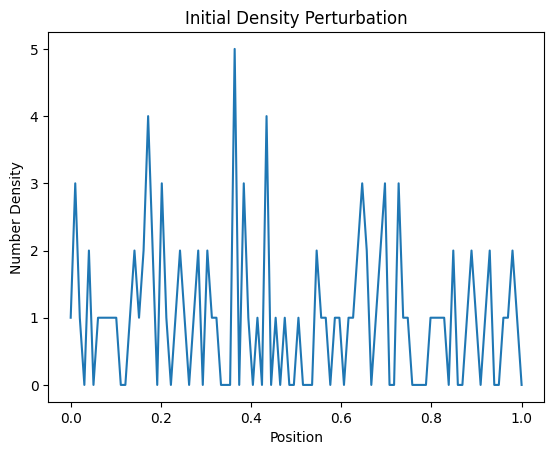

In [735]:
position_grid = np.linspace(0, 1, N_divisions_x)
number_electrons_in_bins, b = np.histogram(np.array(positions_x), bins=100, range=(0, length_domain_x))
number_density = number_electrons_in_bins / (number_of_electrons / divisions_domain_x)

plt.plot(position_grid, number_density)
plt.xlabel('Position')
plt.ylabel('Number Density')
plt.title('Initial Density Perturbation')
plt.show()

In [736]:
# Time parameters
start_time = 0
end_time   = 1
dt         = 0.002
time       = np.arange(start_time,end_time + dt,dt,dtype = np.double)

In [737]:
# Some variables for storing data
Ex_max       = np.zeros(len(time), dtype = np.double)
Ey_max       = np.zeros(len(time), dtype = np.double)

In [738]:
# Charge deposition using linear weighting scheme
rho_electrons  = cloud_charge_deposition(charge_electron,number_of_electrons,positions_x,positions_y,x_grid,y_grid,charge_b1_depositor,ghost_cells,length_domain_x,length_domain_y,dx,dy)
rho_initial    = norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron)

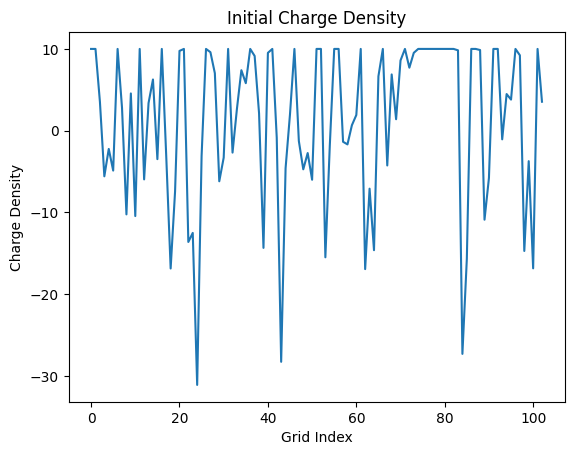

<Figure size 640x480 with 0 Axes>

In [739]:
plt.plot(np.array(rho_initial)[1, :])
plt.title('Initial Charge Density')
plt.xlabel('Grid Index')
plt.ylabel('Charge Density')
plt.show()
plt.clf()

In [740]:
Ex_initial_centered = np.zeros((y_grid.size, x_grid.size))
Ey_initial_centered = np.zeros((y_grid.size, x_grid.size))

rho_physical = rho_initial[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells].copy()

Ex_temp, Ey_temp = poisson_solver(rho_physical, dx, dy)

Ex_initial_centered[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells] = Ex_temp.T  #copy()
Ey_initial_centered[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells] = Ey_temp.T  #copy()

In [741]:
Ex_initial_Yee = 0.5 * (Ex_initial_centered + np.roll(Ex_initial_centered, -1, axis=1))
Ex_initial_Yee = periodic_ghost(Ex_initial_Yee, ghost_cells)

Ey_initial_Yee = 0.5 * (Ey_initial_centered + np.roll(Ey_initial_centered, -1, axis=0))
Ey_initial_Yee = periodic_ghost(Ey_initial_Yee, ghost_cells)

In [742]:
# Obtain v at (t = 0.5dt) to implement the Verlet algorithm
positions_x_half = positions_x + velocity_x * dt / 2
positions_y_half = positions_y + velocity_y * dt / 2

# Periodic Boundary conditions for particles
positions_x_half, positions_y_half = periodic_particles(positions_x_half, positions_y_half, length_domain_x, length_domain_y)

# Finding interpolant fractions for the positions
fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_half, positions_y_half, x_right, y_grid, dx, dy)
fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_half, positions_y_half, x_grid, y_top, dx, dy)

# Interpolating the fields at each particle
Ex_particle = interpolate_field(Ex_initial_Yee, fracs_Ex_y, fracs_Ex_x)
Ey_particle = interpolate_field(Ey_initial_Yee, fracs_Ey_y, fracs_Ey_x)

# Updating the velocity using the interpolated Electric fields to find v at (t = 0.5dt)
velocity_x += (Ex_particle * charge_electron / mass_electron) * dt / 2
velocity_y += (Ey_particle * charge_electron / mass_electron) * dt / 2

Ex = Ex_initial_Yee.copy()
Ey = Ey_initial_Yee.copy()
Bz = np.zeros_like(Ey_initial_Yee)

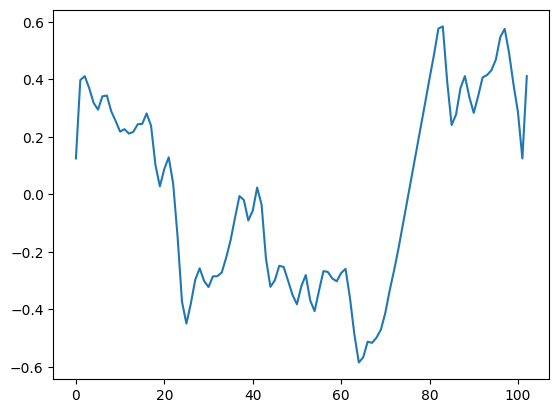

<Figure size 640x480 with 0 Axes>

In [743]:
plt.plot(np.array(Ex_initial_Yee)[1, :])
plt.show()
plt.clf()

In [744]:
for time_index in range(len(time)):
    if time_index % 25 == 0:
        print('Computing for time = ', time_index * dt)

    # Updating the positions of particles using the velocities (Verlet algorithm)
    # velocity at t = (n + 1/2) dt, positions_x at t = (n)dt, and positions_x_new
    # at t = (n+1)dt
    positions_x_new = positions_x + velocity_x * dt
    positions_y_new = positions_y + velocity_y * dt

    # Applying periodic boundary conditions for particles
    positions_x_new, positions_y_new = periodic_particles(positions_x_new, positions_y_new,length_domain_x, length_domain_y)

    # Computing the current densities on the Yee grid provided by Umeda's scheme
    Jx_Yee, Jy_Yee = umeda_2003(charge_electron,number_of_electrons,positions_x, positions_y,velocity_x, velocity_y,x_grid, y_grid,ghost_cells,length_domain_x, length_domain_y,dx, dy,dt)

    # Normalizing and evaluating the current densities on the centered grid
    Jx_norm_Yee = current_norm_BC_Jx(Jx_Yee, number_of_electrons, w_p,ghost_cells)
    Jy_norm_Yee = current_norm_BC_Jy(Jy_Yee, number_of_electrons, w_p,ghost_cells)

    # Evolving electric fields using currents
    Ex_updated, Ey_updated, Bz_updated = fdtd(Ex, Ey, Bz, length_domain_x,length_domain_y, ghost_cells,Jx_norm_Yee, Jy_norm_Yee,dt)
    # Forcing Bz to be zero
    Bz_updated[:, :] = 0

    # calculating the interpolation fractions needed for 2D interpolation
    fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_new, positions_y_new,x_right, y_grid, dx, dy)
    fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_new, positions_y_new,x_grid, y_top, dx, dy)
    fracs_Bz_x, fracs_Bz_y = fraction_finder(positions_x_new, positions_y_new,x_right, y_top, dx, dy)

    # Interpolating the fields at particle locations
    Ex_particle = interpolate_2D(Ex_updated, fracs_Ex_y, fracs_Ex_x)
    Ey_particle = interpolate_2D(Ey_updated, fracs_Ey_y, fracs_Ey_x)

    # Computing the interpolated magnetic field at t = (n+1)*dt to push v((n+1/2) * dt)
    Bz_particle = interpolate_2D((Bz_updated + Bz) / 2, fracs_Bz_y, fracs_Bz_x)

    # Updating the velocity using the interpolated Electric fields
    velocity_x_new, velocity_y_new = Boris(charge_electron, mass_electron,velocity_x, velocity_y, dt,Ex_particle, Ey_particle, Bz_particle)

    # Saving the Electric fields for plotting
    Ex_max[time_index] = np.max(np.abs(Ex[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells]))
    Ey_max[time_index] = np.max(np.abs(Ey[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells]))

    # Saving the updated velocities for the next timestep
    velocity_x = velocity_x_new.copy()
    positions_x = positions_x_new.copy()
    velocity_y = velocity_y_new.copy()
    positions_y = positions_y_new.copy()
    Ex = Ex_updated.copy()
    Ey = Ey_updated.copy()

Computing for time =  0.0


ValueError: object too deep for desired array

In [ ]:
h5f = h5py.File('PIC_2D_CD.h5', 'w')
h5f.create_dataset('Ex_amp', data = (Ex_max))
h5f.create_dataset('Ey_amp', data = (Ey_max))
h5f.close()

In [ ]:
# Open the HDF5 file in read mode
with h5py.File('CK_256.h5', 'r') as h5f:
    # Read the dataset 'max_E' into the variable Ex_max_CK
    Ex_max_CK = h5f['max_E'][:]
# Create a time array with the same length as Ex_max_CK
time_CK = np.linspace(0, time[-1], len(Ex_max_CK))

In [ ]:
# Create a time grid
time_grid = np.linspace(0, time[-1], len(Ex_max))

# Plot the maximum electric field amplitude for PIC and Cheng Knorr
plt.plot(time_grid, Ex_max, label=r'$\mathrm{PIC}$')
plt.plot(time_CK, Ex_max_CK, label=r'$\mathrm{Cheng\ Knorr}$')

# Add labels and legend
plt.xlabel('$t$')
plt.ylabel('$\mathrm{MAX}(|E_{x}|)$')
plt.legend()

# Display the plot
plt.show()

# Save the plot as an image file
plt.savefig('MaxE.png')

# Clear the current figure to release memory
plt.clf()

In [ ]:
# Plot the maximum electric field amplitude for PIC and Cheng Knorr using semilogy
plt.semilogy(time_grid, Ex_max, label=r'$\mathrm{PIC}$')
plt.semilogy(time_CK, Ex_max_CK, label=r'$\mathrm{Cheng\ Knorr}$')

# Add labels and legend
plt.xlabel('$t$')
plt.ylabel('$\mathrm{MAX}(|E_{x}|)$')
plt.legend()

# Display the plot
plt.show()

# Save the plot as an image file
plt.savefig('MaxE_semilogy.png')

# Clear the current figure to release memory
plt.clf()

In [ ]:
# Plot the maximum electric field amplitude for PIC and Cheng Knorr using loglog
plt.loglog(time_grid, Ex_max, label=r'$\mathrm{PIC}$')
plt.loglog(time_CK, Ex_max_CK, label=r'$\mathrm{Cheng\ Knorr}$')

# Add labels and legend
plt.xlabel('$t$')
plt.ylabel('$\mathrm{MAX}(|E_{x}|)$')
plt.legend()

# Display the plot
plt.show()

# Save the plot as an image file
plt.savefig('MaxE_loglog.png')

# Clear the current figure to release memory
plt.clf()